In [59]:
import sys

sys.path.append("../../")

In [60]:
import gymnasium as gym
from vectorhash import build_vectorhash_architecture
from shifts import RatShift
from smoothing import RatSLAMSmoothing
from miniworld.params import DEFAULT_PARAMS
from miniworld_agent import MiniworldVectorhashAgent
import math
import torch
from preprocessing_cnn import GrayscaleAndFlattenPreprocessing, PreprocessingCNN
import matplotlib.pyplot as plt
from graph_utils import plot_probability_distribution_on_ax, error_test
import copy


### vhash
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

shapes = [(5, 5, 5), (8, 8, 8)]
N = 10


def make_env():
    params = DEFAULT_PARAMS.copy().no_random()
    env = gym.make(
        "MiniWorld-CollectHealth-v0",
        max_episode_steps=-1,
        params=params,
        domain_rand=False,
    )
    min_x = env.get_wrapper_attr("min_x")
    max_x = env.get_wrapper_attr("max_x")
    min_z = env.get_wrapper_attr("min_z")
    max_z = env.get_wrapper_attr("max_z")

    limits = torch.tensor([max_x - min_x, max_z - min_z, 2 * math.pi]).float()
    return env, limits


env_cnn, limits = make_env()
env_no_cnn, limits = make_env()
model_cnn = build_vectorhash_architecture(
    shapes,
    N_h=600,
    input_size=128,
    initalization_method="by_sparsity",
    limits=limits,
    device=device,
    shift=RatShift(),
    smoothing=RatSLAMSmoothing(device=device),
)
model_no_cnn = build_vectorhash_architecture(
    shapes,
    N_h=600,
    input_size=60 * 80,
    initalization_method="by_sparsity",
    limits=limits,
    device=device,
    shift=RatShift(),
    smoothing=RatSLAMSmoothing(device=device),
)

#### preprocessor
cnn_preproc = PreprocessingCNN(
    device=device,
    latent_dim=128,
    input_channels=3,
    target_size=(224, 224),
    model_path="resnet18_adapter.pth",
)

grayscale_flatten_preproc = GrayscaleAndFlattenPreprocessing(device=device)

#### agents
agent_cnn = MiniworldVectorhashAgent(model_cnn, env_cnn, preprocessor=cnn_preproc)

agent_no_cnn = MiniworldVectorhashAgent(
    model_no_cnn, env_no_cnn, preprocessor=grayscale_flatten_preproc
)

by_sparsity
module shapes:  [(5, 5, 5), (8, 8, 8)]
N_g     :  637
N_patts :  64000
N_h     :  600
by_sparsity
module shapes:  [(5, 5, 5), (8, 8, 8)]
N_g     :  637
N_patts :  64000
N_h     :  600


/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


info for each h directly after learning it
h max, min, mean tensor(6.4014, device='cuda:0') tensor(0., device='cuda:0') tensor(1.7612, device='cuda:0')
h_from_s max, min, mean tensor(6.4001, device='cuda:0') tensor(0., device='cuda:0') tensor(1.7608, device='cuda:0')
h_from_s_denoised max, min, mean tensor(1.9960, device='cuda:0') tensor(1.4286, device='cuda:0') tensor(1.7138, device='cuda:0')
avg nonzero/greaterzero h from book: tensor(548, device='cuda:0') tensor(548, device='cuda:0')
avg nonzero/greaterzero h from s: tensor(548, device='cuda:0') tensor(548, device='cuda:0')
avg nonzero/greaterzero h from s denoised: tensor(600, device='cuda:0') tensor(600, device='cuda:0')
mse/cosinesimilarity h from book and h from s tensor(2.0838e-07, device='cuda:0') tensor([1.], device='cuda:0')
mse/cosinesimilarity h from book and h from s denoised tensor(1.5319, device='cuda:0') tensor([0.8181], device='cuda:0')
mse/cosinesimilarity s and s from h from s tensor(3.9995e-10, device='cuda:0') ten

/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:102: UserWarning: Using a target size (torch.Size([1, 600])) that is different to the input size (torch.Size([600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s),
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:109: UserWarning: Using a target size (torch.Size([1, 600])) that is different to the input size (torch.Size([600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s_denoised),
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:125: UserWarning: Using a target size (torch.Size([1, 128])) that is different to the input size (torch.S

In [61]:
start_state = agent_no_cnn.vectorhash.scaffold.g
print("start state:", start_state)
print("grid limits:", agent_no_cnn.vectorhash.scaffold.grid_limits)
print("world limits:", limits)
print("scale factor:", agent_no_cnn.vectorhash.scaffold.scale_factor)

start state: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.,

In [62]:
begin = agent_no_cnn.get_true_pos(env_no_cnn)
end = begin + 1 / agent_no_cnn.vectorhash.scaffold.scale_factor
dist = torch.distributions.uniform.Uniform(low=begin, high=end)
samples = dist.sample((N,))
grid_states = agent_no_cnn.vectorhash.scaffold.scale_factor * (samples - begin)

In [63]:
print("samples:", samples)
print("grid states:", grid_states)

samples: tensor([[ 3.0032,  9.1007, -1.5483],
        [ 3.0297,  8.8446, -1.4705],
        [ 2.8914,  9.0609, -1.5251],
        [ 3.0643,  9.0711, -1.5448],
        [ 2.9823,  8.7696, -1.4365],
        [ 3.0680,  9.1273, -1.4293],
        [ 2.8686,  9.0216, -1.4485],
        [ 2.9036,  9.0127, -1.4005],
        [ 3.0293,  8.9977, -1.4251],
        [ 2.7918,  9.0366, -1.4464]], device='cuda:0')
grid states: tensor([[0.6849, 0.8702, 0.0154],
        [0.7512, 0.2301, 0.5108],
        [0.4055, 0.7708, 0.1634],
        [0.8378, 0.7963, 0.0377],
        [0.6328, 0.0425, 0.7271],
        [0.8468, 0.9366, 0.7729],
        [0.3484, 0.6724, 0.6510],
        [0.4360, 0.6501, 0.9567],
        [0.7503, 0.6126, 0.7999],
        [0.1564, 0.7099, 0.6643]], device='cuda:0')


info for each h directly after learning it
h max, min, mean tensor(6.0350, device='cuda:0') tensor(0., device='cuda:0') tensor(1.8600, device='cuda:0')
h_from_s max, min, mean tensor(6.0349, device='cuda:0') tensor(0., device='cuda:0') tensor(1.8600, device='cuda:0')
h_from_s_denoised max, min, mean tensor(2.0310, device='cuda:0') tensor(1.4129, device='cuda:0') tensor(1.7233, device='cuda:0')
avg nonzero/greaterzero h from book: tensor(550, device='cuda:0') tensor(550, device='cuda:0')
avg nonzero/greaterzero h from s: tensor(550, device='cuda:0') tensor(550, device='cuda:0')
avg nonzero/greaterzero h from s denoised: tensor(600, device='cuda:0') tensor(600, device='cuda:0')
mse/cosinesimilarity h from book and h from s tensor(2.5327e-11, device='cuda:0') tensor([1.], device='cuda:0')
mse/cosinesimilarity h from book and h from s denoised tensor(1.4464, device='cuda:0') tensor([0.8415], device='cuda:0')
mse/cosinesimilarity s and s from h from s tensor(5.9971e-11, device='cuda:0') ten

/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:102: UserWarning: Using a target size (torch.Size([1, 600])) that is different to the input size (torch.Size([600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s),
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:109: UserWarning: Using a target size (torch.Size([1, 600])) that is different to the input size (torch.Size([600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s_denoised),
/home/ezrahuang/Projects/rl-research/vectorhash/experiments/miniworld_grid_state_probs_cnn_no_cnn/../../vectorhash.py:125: UserWarning: Using a target size (torch.Size([1, 4800])) that is different to the input size (torch.

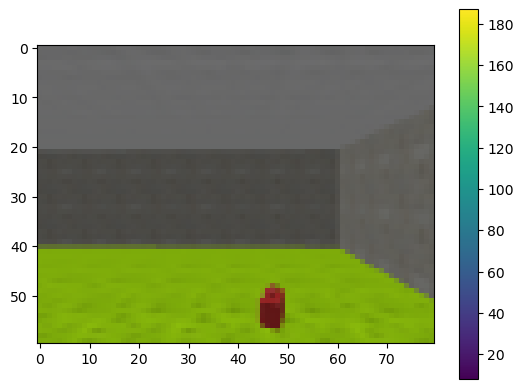

In [64]:
first_img, first_pos = agent_no_cnn._env_reset(env_cnn)
first_img, first_pos = agent_no_cnn._obs_postpreprocess(agent_no_cnn.env.step(4), 4)
m = plt.imshow(first_img)
plt.colorbar(m)
agent_no_cnn.vectorhash.store_memory(s=agent_no_cnn.preprocessor.encode(first_img))
agent_cnn.vectorhash.store_memory(s=agent_cnn.preprocessor.encode(first_img))

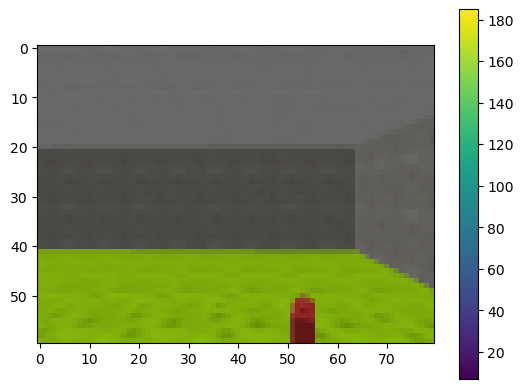

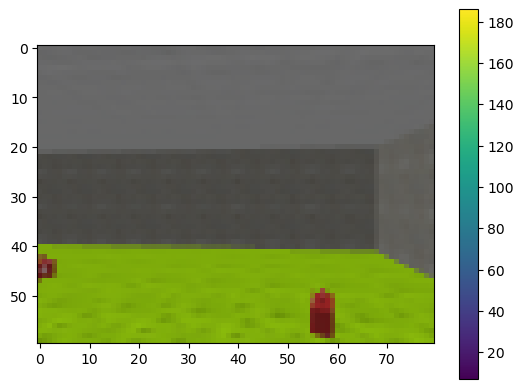

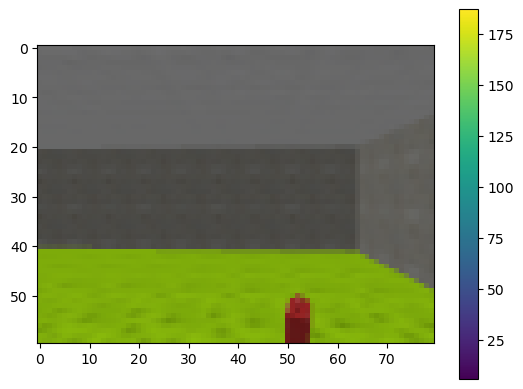

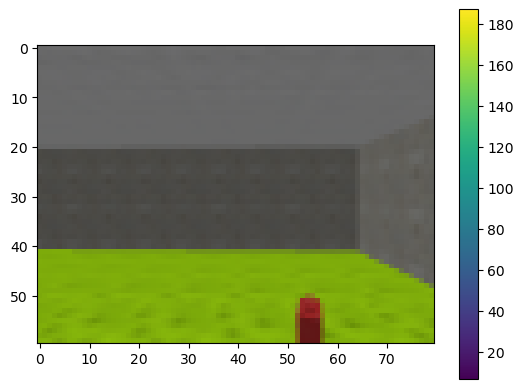

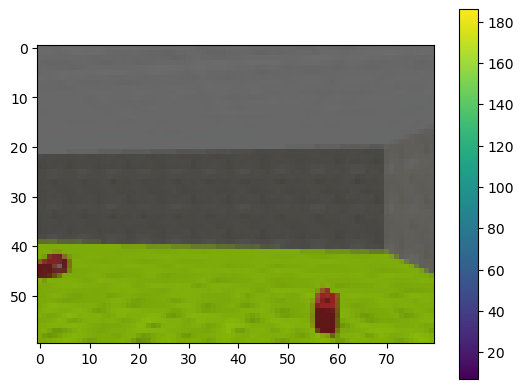

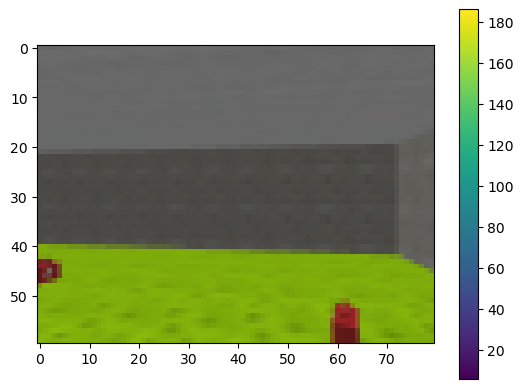

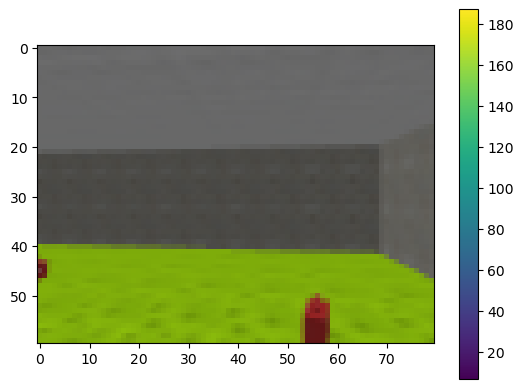

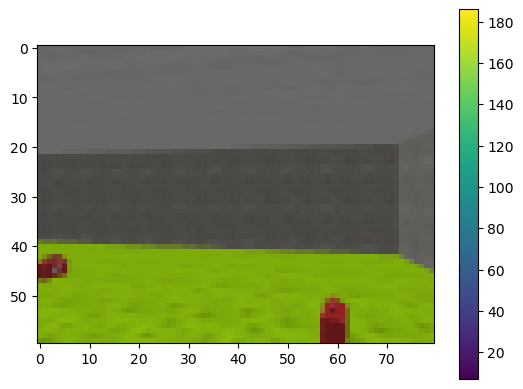

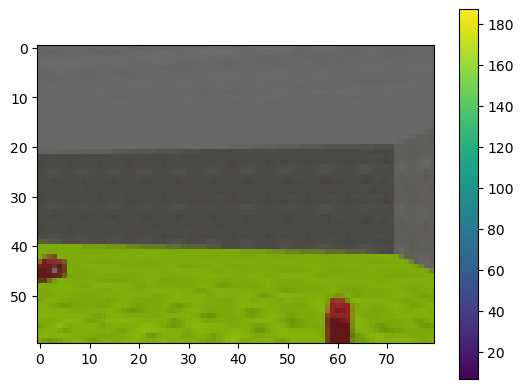

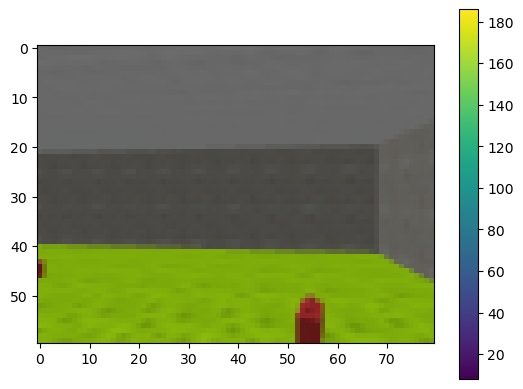

In [65]:
imgs = []
states_cnn = []
states_no_cnn = []
for sample in samples:
    pos = sample.cpu().numpy()
    agent_no_cnn.set_agent_pos(pos)
    agent_cnn.set_agent_pos(pos)
    img, _ = agent_no_cnn._obs_postpreprocess(agent_no_cnn.env.step(4), 4)
    obs_cnn = agent_cnn.preprocessor.encode(img)
    obs_no_cnn = agent_no_cnn.preprocessor.encode(img)
    g_cnn = agent_cnn.vectorhash.scaffold.denoise(
        agent_cnn.vectorhash.scaffold.grid_from_hippocampal(
            agent_cnn.vectorhash.hippocampal_sensory_layer.hippocampal_from_sensory(
                obs_cnn
            )
        )
    )
    g_no_cnn = agent_no_cnn.vectorhash.scaffold.denoise(
        agent_no_cnn.vectorhash.scaffold.grid_from_hippocampal(
            agent_no_cnn.vectorhash.hippocampal_sensory_layer.hippocampal_from_sensory(
                obs_no_cnn
            )
        )
    )
    m = plt.imshow(img)
    plt.colorbar(m)
    plt.show()
    imgs.append(img)
    states_cnn.append(g_cnn)
    states_no_cnn.append(g_no_cnn)

Text(0.5, 0.98, 'probability mass across g (cnn)')

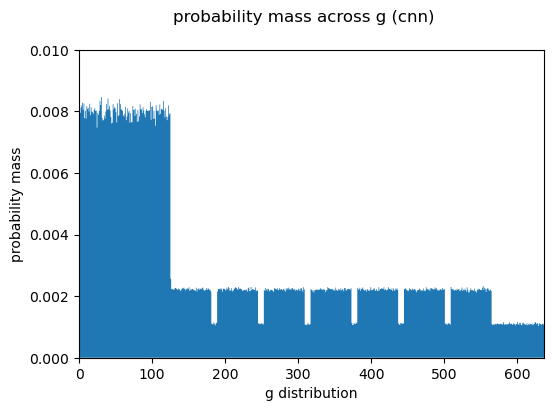

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

plot_probability_distribution_on_ax(states_cnn[0][0].cpu(), ax)

ax.set_ylim(0, 0.01)
ax.set_xlim(0, len(states_cnn[0][0]))
ax.set_ylabel("probability mass")

ax.set_xlabel("g distribution")

fig.suptitle("probability mass across g (cnn)")

In [67]:
fig.savefig('results_across_g_cnn.png')

Text(0.5, 0.98, 'probability mass across g (no_cnn)')

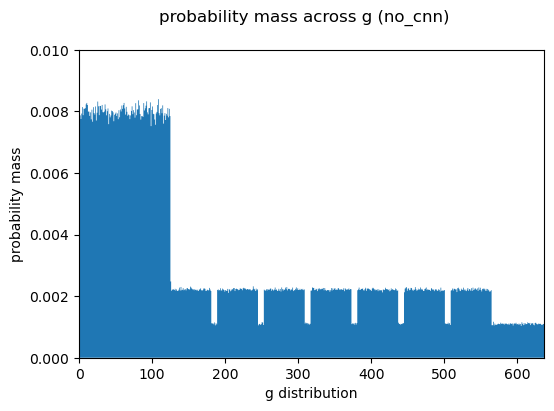

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

plot_probability_distribution_on_ax(states_no_cnn[0][0].cpu(), ax)

ax.set_ylim(0, 0.01)
ax.set_xlim(0, len(states_cnn[0][0]))
ax.set_ylabel("probability mass")

ax.set_xlabel("g distribution")

fig.suptitle("probability mass across g (no_cnn)")

In [69]:
fig.savefig('results_across_g_no_cnn.png')

In [70]:
cnn_x_dists = []
cnn_y_dists = []
cnn_theta_dists = []
no_cnn_x_dists = []
no_cnn_y_dists = []
no_cnn_theta_dists = []

for i in range(N):
    agent_cnn.vectorhash.scaffold.modules = (
        agent_cnn.vectorhash.scaffold.modules_from_g(states_cnn[i][0])
    )
    agent_no_cnn.vectorhash.scaffold.modules = (
        agent_no_cnn.vectorhash.scaffold.modules_from_g(states_no_cnn[i][0])
    )

    cnn_x_dists.append(agent_cnn.vectorhash.scaffold.expand_distribution(0).cpu())
    cnn_y_dists.append(agent_cnn.vectorhash.scaffold.expand_distribution(1).cpu())
    cnn_theta_dists.append(agent_cnn.vectorhash.scaffold.expand_distribution(2).cpu())
    no_cnn_x_dists.append(agent_no_cnn.vectorhash.scaffold.expand_distribution(0).cpu())
    no_cnn_y_dists.append(agent_no_cnn.vectorhash.scaffold.expand_distribution(1).cpu())
    no_cnn_theta_dists.append(agent_no_cnn.vectorhash.scaffold.expand_distribution(2).cpu())

Text(0.5, 0.98, 'probability mass across dimension distributions (cnn)')

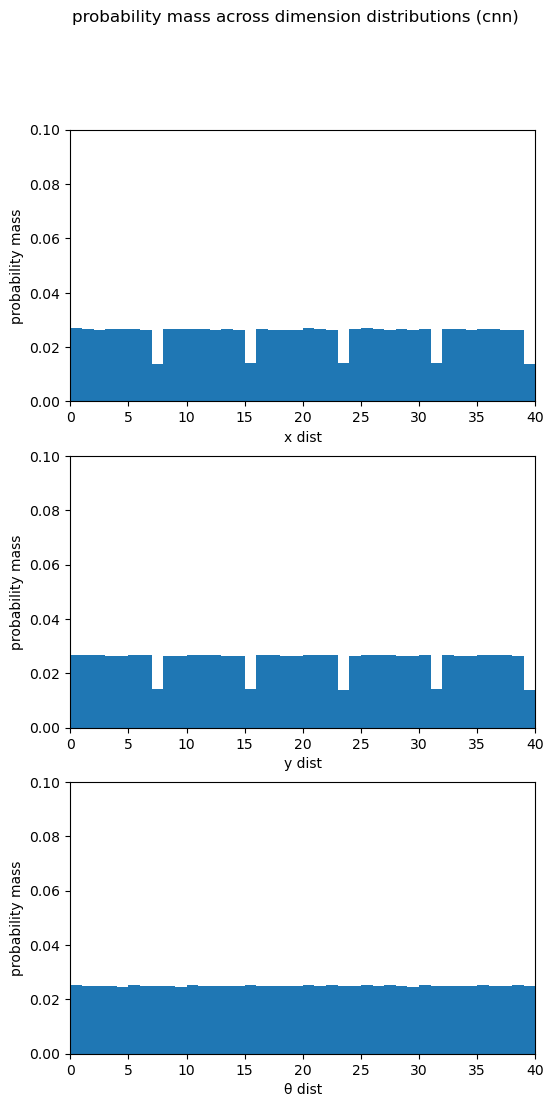

In [71]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 12))

plot_probability_distribution_on_ax(cnn_x_dists[0], axs[0])
axs[0].set_xlabel('x dist')
axs[0].set_xlim(0, len(cnn_x_dists[0]))

plot_probability_distribution_on_ax(cnn_y_dists[0], axs[1])
axs[1].set_xlabel('y dist')
axs[1].set_xlim(0, len(cnn_y_dists[0]))

plot_probability_distribution_on_ax(cnn_theta_dists[0], axs[2])
axs[2].set_xlabel('θ dist')
axs[2].set_xlim(0, len(cnn_theta_dists[0]))

for i in range(3):
  axs[i].set_ylabel('probability mass')
  axs[i].set_ylim(0, 0.1)

fig.suptitle("probability mass across dimension distributions (cnn)")

In [72]:
fig.savefig("results_across_dims_cnn.png")

Text(0.5, 0.98, 'probability mass across dimension distributions (no cnn)')

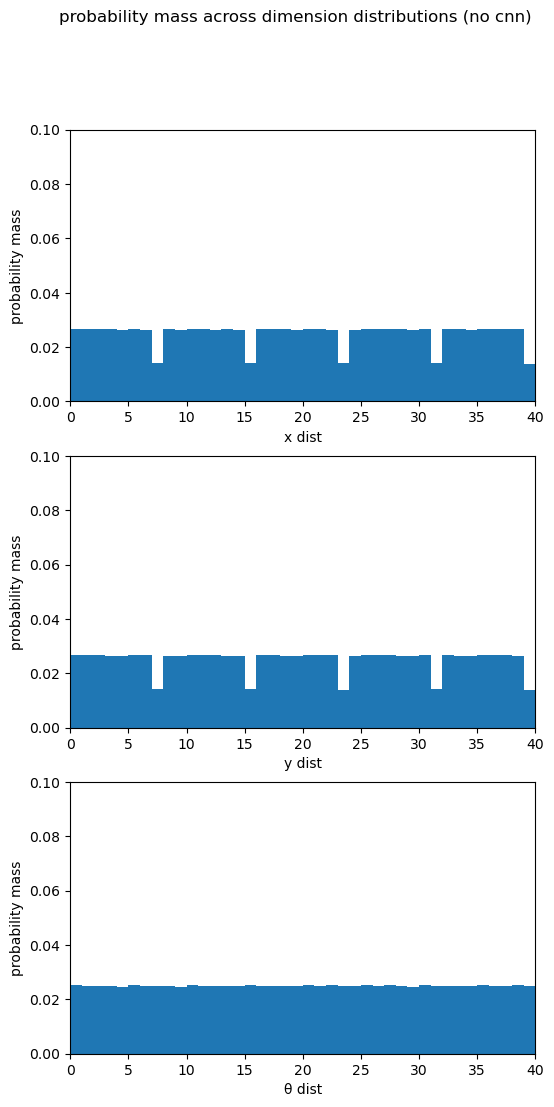

In [73]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 12))

plot_probability_distribution_on_ax(no_cnn_x_dists[0], axs[0])
axs[0].set_xlabel('x dist')
axs[0].set_xlim(0, len(no_cnn_x_dists[0]))

plot_probability_distribution_on_ax(cnn_y_dists[0], axs[1])
axs[1].set_xlabel('y dist')
axs[1].set_xlim(0, len(no_cnn_y_dists[0]))

plot_probability_distribution_on_ax(cnn_theta_dists[0], axs[2])
axs[2].set_xlabel('θ dist')
axs[2].set_xlim(0, len(no_cnn_theta_dists[0]))

for i in range(3):
  axs[i].set_ylabel('probability mass')
  axs[i].set_ylim(0, 0.1)

fig.suptitle("probability mass across dimension distributions (no cnn)")

In [74]:
fig.savefig("results_across_dims_no_cnn.png")

In [75]:
errors_cnn = torch.zeros(N, 3)
errors_no_cnn = torch.zeros(N, 3)

scaffold_cnn_copy = copy.deepcopy(model_cnn.scaffold)
scaffold_no_cnn_copy = copy.deepcopy(model_no_cnn.scaffold)

for i, state in enumerate(states_cnn):
    scaffold_cnn_copy.modules = scaffold_cnn_copy.modules_from_g(state[0])
    for d in range(3):
        errors_cnn[i, d] = error_test(0, scaffold_cnn_copy.expand_distribution(d))

for i, state in enumerate(states_no_cnn):
    scaffold_no_cnn_copy.modules = scaffold_no_cnn_copy.modules_from_g(state[0])
    for d in range(3):
        errors_no_cnn[i, d] = error_test(0, scaffold_no_cnn_copy.expand_distribution(d))

In [78]:
print(errors_cnn.mean(dim=0))
print(errors_no_cnn.mean(dim=0))



tensor([10.0112, 10.0123,  9.9997])
tensor([10.0109, 10.0129, 10.0000])
